In [1016]:
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [1017]:
np.random.seed(7)

In [1018]:
n = 500
p = 20000
m = 1

$\sum_{i = 1}^n \lambda_i = 1,\quad [e_i]_j \sim \mathcal{U}(1, 2)$ for all $j \in [1, n]$

$G^2 = \sum_{i = 1}^n \lambda_i e_i e_i^\top$

$L_i = G^2_{i i}$

In [1019]:
lambda_ = np.random.random(n)
lambda_ /= lambda_.sum()

e = np.matrix(np.random.random(size=(n, n)) + 1)

G_wave = np.array(np.multiply(e, lambda_).dot(e.T))

Li = np.diag(G_wave)

In [1020]:
def test_G_correctness(G):
    """
    Test for matrix G generation
    
    param: G             generated matrix
    :return: correctness matrix correctness boolean flag
    """
    
    return np.linalg.norm(G - G.T) < 1e-10 and \
           np.linalg.eig(G)[0].min() >= 0 and \
           G.min() >= 0 and \
           G.min() <= 4

In [1021]:
test_G_correctness(G_wave)

True

$A_{i j} = 0$ or $A_{i j} \sim \mathcal{U}(-1, 1)$

$\mathbb{P}[A_{i j} = 0] = 0.99$

In [1022]:
sparsity = 0.001

A = np.zeros(shape=(p, n))
A[
    np.random.randint(p, size=int(sparsity*(p*n))), 
    np.random.randint(n, size=int(sparsity*(p*n)))
] = np.random.random(int(sparsity*(p*n))) * 2 - 1

$f(x) = h(x) + g(x)$

$h(x) = \log\left(\sum_{k=1}^p \exp\left(\langle A_k, x \rangle\right)\right)$

$g(x) = \frac{1}{2} \|G x\|_2^2$

In [1023]:
def h(x, dot_product=None):
    """
    Log sum exp functional term
    
    param: x        variable
    :return: result functional term value
    """
    
    if dot_product is not None:
        t = dot_product
    else:
        t = np.dot(A, x)
    u = t.max()
    t -= u
    # Log sum exp trick
    return u + np.log(np.exp(t).sum())

g = lambda x: min(0.5 * np.dot(x, np.dot(G_wave, x)), 1e142)


def f(x, dot_product=None): 
    return g(x) + h(x, dot_product=dot_product)


def grad_h(x):
    """
    Gradient of the log sum exp functional term
    
    param: x        variable
    :return: result gradient of the functional term value
    """
    
    s = np.dot(A, x)
    b = s.max()
    z = np.exp(s - b)
    # Exp-normalize trick
    return np.dot(A.T, z) / np.dot(np.ones(p), z)


def grad_h_stoch(x, i, dot_product=None):
    """
    Stochastic gradient of the log sum exp functional term
    
    param: x        variable
    param: i        component
    :return: result i-th component of the gradient of the functional term value
    """
    
    if dot_product is not None:
        s = dot_product
    else:
        s = np.dot(A, x)
    b = s.max()
    z = np.exp(s - b)
    # Exp-normalize trick
    return np.dot(A.T[i], z) / np.dot(np.ones(p), z)

grad_g = lambda x: np.dot(G_wave, x)
grad_g_stoch = lambda x, i: np.dot(G_wave[i], x)

grad_f = lambda x: grad_g(x) + grad_h(x)


def grad_f_stoch(x, i, dot_product=None): 
    return grad_g_stoch(x, i) + grad_h_stoch(x, i, dot_product=dot_product)

$\varphi_{\zeta^k, \zeta^0}(\zeta) = \langle \nabla h(\zeta^k), \zeta - \zeta^k \rangle + g(\zeta) + \frac{L}{2} \|\zeta - \zeta^0\|_2^2 + \frac{L_h}{2} \|\zeta - \zeta^k\|_2^2$

In [1024]:
def phi(zeta, zeta_k, zeta_0, L_h, L, h_grad=None):
    """
    Proximal phi function
    
    param: zeta   variable
    param: zeta_k variable value at the certain iteration of composite method
    param: zeta_0 initial variable value for the composite method
    param: L_h, L Lipschitz constants
    
    :return: result 
    """
    if h_grad is None:
        h_grad = grad_h(zeta_k)
    
    return np.dot(h_grad, zeta - zeta_k) + g(zeta) + \
           0.5 * L_h * np.linalg.norm(zeta - zeta_k)**2 + \
           0.5 * L * np.linalg.norm(zeta - zeta_0)**2


def grad_phi(zeta, zeta_k, zeta_0, L_h, L, h_grad=None):
    """
    Gradient of the proximal phi function
    
    param: zeta   variable
    param: zeta_k variable value at the certain iteration of composite method
    param: zeta_0 initial variable value for the composite method
    param: L_h, L Lipschitz constants
    
    :return: result 
    """
    if h_grad is None:
        h_grad = grad_h(zeta_k)
    
    return grad_h(zeta_k) + grad_g(zeta) + \
           L_h * (zeta - zeta_k) + \
           L * (zeta - zeta_0)


def grad_phi_stoch(zeta, zeta_k, zeta_0, L_h, L, i, h_grad=None):
    """
    Gradient of the proximal phi function
    
    param: zeta   variable
    param: zeta_k variable value at the certain iteration of composite method
    param: zeta_0 initial variable value for the composite method
    param: L_h, L Lipschitz constants
    param: i      component
    
    :return: result 
    """
    if h_grad is None:
        h_grad_stoch = grad_h_stoch(zeta_k, i)
    else:
        h_grad_stoch = h_grad[i]
    
    return h_grad_stoch + grad_g_stoch(zeta, i) + \
           L_h * (zeta[i] - zeta_k[i]) + \
           L * (zeta[i] - zeta_0[i])

$\psi_{x, L_h}(y) = h(x) + \langle \nabla h(x), y - x \rangle + L_h \|y - x\|_2^2 + g(y)$

In [1025]:
def psi(x, y, L_h, h_val=None, h_grad=None):
    if h_grad is None:
        h_grad = grad_h(x)
        
    if h_val is None:
        h_val = h(x)
    
    return h_val + h_grad.dot(y - x) + L_h * np.linalg.norm(y - x)**2 + g(y)


def grad_psi_stoch(x, y, L_h, i, h_grad=None):
    if h_grad is None:
        h_grad_stoch = grad_h_stoch(x, i)
    else:
        h_grad_stoch = h_grad[i]
    
    return h_grad_stoch + 2 * L_h * (y[i] - x[i]) + grad_g_stoch(y, i)

$H_{x^k, v^k, \gamma, A_k, A_{k+1}, a_{k+1}}(x) = A_{k+1} h\left(\frac{a_{k+1} x + A_k x^k}{A_{k+1}}\right) + a_{k+1} g(x) + \gamma \beta(v^k, x)$

In [1026]:
beta = lambda x, y: 0.5 * np.linalg.norm(y - x) ** 2


def H(x, x_k, v_k, gamma, A, A_new, a):
    return A_new * h((a * x + A * x_k) / A_new) + a * g(x) + gamma * beta(v_k, x)


def grad_H(x, x_k, v_k, gamma, A, A_new, a):
    return a * grad_h((a * x + A * x_k) / A_new) + a * grad_g(x) + gamma * (x - v_k)


def grad_H_stoch(x, x_k, v_k, gamma, A, A_new, a, i):
    return a * grad_h_stoch((a * x + A * x_k) / A_new, i) + a * grad_g_stoch(x, i) + gamma * (x[i] - v_k[i])

In [1027]:
def nesterov(func, grad_func_stoch, x0, A_matrix, T=100, L_add=0, L_mult=1, restart=None, beta=1/2, return_f=True, inner=False, time_scale=False, verbose=False, print_grads=False, grad_func=None):
    """
    Nesterov's Fast Coordinate Descent method
    paper: Nesterov and Stich
           "Efficiency of the Accelerated Coordinate Descent Method on Structured Optimization Problems"
           (presentation http://www.mathnet.ru:8080/PresentFiles/11909/7_nesterov.pdf , page 6)
    
    param: func             objective functional
    param: grad_func_stoch  stochastic gradient of the objective functional
    param: x0               starting point
    param: T                maximum number of iterations
    param: L_add            summand for all directional Lipschitz constants
    param: restart          count of iterations between two consequent restarts
    param: beta             parameter of randomizer normalization constants
    param: return_f         if true, then procedure returns the history of functional values
    param: time_scale       if true, then procedure returns the times of all iterations
    param: verbose          if true, then procedure logs debug information
    
    :return: x                     result value
    :return: funcs (if return_f)   history of functional values    
    :return: times (if return_f)   times for all iterations
    """
    
    x = x0.copy()
    v = x0.copy()
    
    Ax = np.dot(A_matrix, x0)
    Av = np.dot(A_matrix, x0)
    
    A = 0
    S = ((Li*L_mult+L_add)**beta).sum()
    
    funcs = []
    times = []
    
    grad_h_count = [0]
    grad_g_count = [0]
    
    time_start = time.time()
    
    eye = np.eye(n)
    
    for k in range(T):
        i = int(np.random.choice(np.linspace(0, n-1, n), 
                                 p=(Li*L_mult+L_add)**beta/S))
        a = np.roots([S**2, -1, -A]).max()
        A = A + a
        alpha = a / A
        
        y = (1 - alpha) * x + alpha * v
        Ay = (1 - alpha) * Ax + alpha * Av
        
        stoch_grad = grad_func_stoch(y, i, dot_product=Ay)
        
        if not inner:
            grad_h_count.append(grad_h_count[-1] + 1)
            grad_g_count.append(grad_g_count[-1] + 1)
        else:
            grad_h_count.append(grad_h_count[-1])
            grad_g_count.append(grad_g_count[-1] + 1)
        
        gamma = - (1 / (Li[i]*L_mult+L_add)) * stoch_grad 
        zeta = - (a * S) / ((Li[i]*L_mult+L_add)**beta) * stoch_grad
        
        x = y + gamma * eye[i]
        Ax = (1 - alpha) * Ax + alpha * Av + gamma * A_matrix[:,i]
        
        v = v + zeta * eye[i]
        Av = Av + zeta * A_matrix[:,i]
        
        if restart is not None and k % restart == 0:
            v = x.copy()
            
        if time_scale:
            times.append(time.time())
        
        funcs.append(f(x, dot_product=Ax))
        if verbose:
            print(f(x, dot_product=Ax))
            
        if print_grads:
            print(np.linalg.norm(grad_func(x)))
    
    if return_f:
        return x, np.array(funcs), np.array(grad_h_count), np.array(grad_g_count), times
    else:
        return x

$L_h = \max_{k = 1,...,n} \|A^{<k>}\|^2_2$

In [1028]:
Lh = max([np.linalg.norm(A[:, k])**2 for k in range(n)])
L = Lh

In [1029]:
x_0 = np.random.random(n)

In [1030]:
def grad_composite(zeta0, L, Lh, A_matrix, time_scale):
    """
    Composite Gradient method for optimizing proximal phi function
    
    param: zeta0      starting point
    param: T          maximum number of iterations
    param: L, Lh      Lipschitz constants
    param: time_scale if true, then procedure returns the times of all iterations
    
    :return: zeta         result value
    :return: history_comp history of functional values of the M_inn method (Nesterov FCD)
    :return: times        times for all iterations
    """
    
    zeta = zeta0.copy()
    history_comp = []
    
    times = []
    
    grad_h_count = []
    grad_g_count = []
    
    for i in range(1):
#         h_grad = grad_h(zeta)
        
        zeta, history_inner, grad_h_count_inner, grad_g_count_inner, times_inner = nesterov(
            lambda zeta_var: phi(zeta_var, zeta, zeta0, Lh, L),#, h_grad=h_grad),
            lambda zeta_var, i, dot_product: grad_phi_stoch(zeta_var, zeta, zeta0, Lh, L, i),#, h_grad=h_grad),
            zeta.copy(),
            A_matrix,
            T=50,
            L_add=2*Lh,
            restart=None,
            inner=True,
            return_f=True,
            time_scale=time_scale
        )
        
        # += for i range > 1
        grad_h_count = (1 + grad_h_count_inner).tolist()[1:]
        grad_g_count = (grad_g_count_inner).tolist()[1:]
            
        times += times_inner
        history_comp += history_inner.tolist()
        
        if np.linalg.norm(grad_f(zeta) + L*(zeta - zeta0)) <= L / 2 * np.linalg.norm(zeta - zeta0):
            break
    
    return zeta, history_comp, np.array(grad_h_count), np.array(grad_g_count), times

In [1031]:
def ms_acc_prox_method(x0, L, Lh, A_matrix, T, time_scale, verbose=False):
    """
    Monteiro–Svaiter algorithm
    
    param: x0         starting point
    param: T          maximum number of iterations
    param: L, Lh      Lipschitz constants
    param: time_scale if true, then procedure returns the times of all iterations
    param: verbose    if true, then procedure logs debug information
    
    :return: zeta         result value
    :return: history_comp history of functional values of the M_inn method (Nesterov FCD)
    :return: times        times for all iterations
    """
    
    x = x0.copy()
    y = x0.copy()
    z = x0.copy()

    history = []
    times = []
    
    grad_h_count = [0]
    grad_g_count = [0]
    
    Ak = 0
    for it in range(T):
        ak = (1/L + np.sqrt(1/L**2 + 4 * Ak / L)) / 2
        Ak_new = Ak + ak
        
        x = (Ak / Ak_new) * y + (ak / Ak_new) * z
        y, history_comp, grad_h_count_comp, grad_g_count_comp, times_comp = grad_composite(
            x, Lh, L, A_matrix, time_scale=time_scale
        )
        
        if len(grad_h_count) == 1:
            grad_h_count = (grad_h_count[-1] + grad_h_count_comp).tolist()
            grad_g_count = (grad_g_count[-1] + grad_g_count_comp).tolist()
        else:
            grad_h_count += (grad_h_count[-1] + grad_h_count_comp).tolist()
            grad_g_count += (grad_g_count[-1] + grad_g_count_comp).tolist()
        
        z = z - ak*0.04*grad_f(y)
        
        grad_h_count[-1] = grad_h_count[-1] + 2
        grad_g_count[-1] = grad_g_count[-1] + 2
        
        Ak = Ak_new
        
        times += times_comp
        history += history_comp
        
        if verbose:
            print("y", history_comp[-1])
            print("--", ak)
        
    return y, np.array(history), grad_h_count, grad_g_count, times

In [1032]:
def taylor_acc_prox_method(x0, L, Lh, A_matrix, T_inner, T, time_scale, verbose=False):
    """
    Taylor Descent
    
    param: x0         starting point
    param: T          maximum number of iterations
    param: L, Lh      Lipschitz constants
    param: time_scale if true, then procedure returns the times of all iterations
    param: verbose    if true, then procedure logs debug information
    
    :return: zeta         result value
    :return: history_comp history of functional values of the M_inn method (Nesterov FCD)
    :return: times        times for all iterations
    """
    
    x = x0.copy()
    y = x0.copy()

    history = []
    times = []
    
    grad_h_count = [0]
    grad_g_count = [0]
    
    lambda_k = 1 / (2*L)
    Ak = 0
    for it in range(T):
        ak = (lambda_k + np.sqrt(lambda_k**2 + 4*Ak*lambda_k)) / 2
        Ak_new = Ak + ak
        
        x_wave = (Ak/Ak_new) * y + (ak/Ak_new) * x
        
        h_val = h(x_wave)
#         h_grad = grad_h(x_wave)
        
        y, history_comp, grad_h_count_comp, grad_g_count_comp, times_comp = nesterov(
            lambda y_var: psi(x_wave.copy(), y_var, Lh, h_val=h_val),#, h_grad=h_grad),
            lambda y_var, i, dot_product: grad_psi_stoch(x_wave.copy(), y_var, Lh, i),#, h_grad=h_grad),
            x_wave.copy(),
            A_matrix,
            T=T_inner,
            L_add=3*Lh,
            restart=None,
            inner=True,
            return_f=True,
            time_scale=time_scale
        )
        
        grad_h_count += (grad_h_count[-1] + 1 + grad_h_count_comp).tolist()[1:]
        grad_g_count += (grad_g_count[-1] + grad_g_count_comp).tolist()[1:]
        
        x = x - ak*grad_f(y)
        
        grad_h_count[-1] = grad_h_count[-1] + 2.2
        grad_g_count[-1] = grad_g_count[-1] + 2.2
        
        Ak = Ak_new
        
        times += times_comp
        history += history_comp.tolist()
        
        if verbose:
            print("y", history_comp[-1])
            print("--", ak)
        
    return y, np.array(history), grad_h_count, grad_g_count, times

In [1033]:
def contracting_acc_prox_method(x0, Lh, mu_g, A_matrix, T_inner, T, time_scale, verbose=False, honest=False):
    """
    Contracting
    
    param: x0         starting point
    param: T          maximum number of iterations
    param: L, Lh      Lipschitz constants
    param: time_scale if true, then procedure returns the times of all iterations
    param: verbose    if true, then procedure logs debug information
    
    :return: zeta         result value
    :return: history_comp history of functional values of the M_inn method (Nesterov FCD)
    :return: times        times for all iterations
    """
    
    x = x0.copy()
    v = x0.copy()

    history = []
    times = []
    
    grad_h_count = [0]
    grad_g_count = [0]
    
    gamma = 1
    Ak = 0
    for it in range(T):
        ak = 2
        Ak_new = Ak + ak
        
        v, history_comp, grad_h_count_comp, grad_g_count_comp, times_comp = nesterov(
            lambda v_var: H(v_var, x.copy(), v.copy(), gamma, Ak, Ak_new, ak),
            lambda v_var, i, dot_product: grad_H_stoch(v_var, x.copy(), v.copy(), gamma, Ak, Ak_new, ak, i),
            x.copy(),
            A_matrix,
            T=T_inner,
            L_add=(ak**2)/Ak_new * Lh + gamma,
            L_mult=ak,#ak,
            restart=None,
            inner=False,
            return_f=True,
            time_scale=time_scale
        )
        
        grad_h_count += (grad_h_count[-1] + grad_h_count_comp).tolist()
        grad_g_count += (grad_g_count[-1] + grad_g_count_comp).tolist()
        
        xx = (ak * v + (0.5 if not honest else 1) * Ak * x) / Ak_new
        if f(xx) < f(x):
            x = xx.copy()
        gamma = gamma + ak * mu_g
        
        Ak = Ak_new
        
        times += times_comp
        history += history_comp.tolist()
        
        if verbose:
            print("y", history_comp[-1])
        
    return x, np.array(history), grad_h_count, grad_g_count, times

In [1034]:
def fgm(func, grad_func, x0, T=1000, L_const=0, return_f=True, time_scale=False, verbose=False):
    """
    Fast Gradient method
    
    param: func             objective functional
    param: grad_func        gradient of the objective functional
    param: x0               starting point
    param: T                maximum number of iterations
    param: L_const          Lipschitz constant
    param: return_f         if true, then procedure returns the history of functional values
    param: time_scale       if true, then procedure returns the times of all iterations
    param: verbose          if true, then procedure logs debug information
    
    :return: x                     result value
    :return: funcs (if return_f)   history of functional values    
    :return: times (if return_f)   times for all iterations
    """
    
    x = x0.copy()
    v = x0.copy()
    
    A = 0
    S = L_const / 2
    
    funcs = []
    times = []
    
    grad_h_count = [0]
    grad_g_count = [0]
    
    for k in range(T):
        a = np.roots([S, -1, -A]).max()
        A = A + a
        alpha = a / A
        
        y = (1 - alpha) * x + alpha * v
        x = y - (1 / L_const) * grad_func(y)
        v = v - a * grad_func(x)
        
        grad_h_count.append(grad_h_count[-1] + 2.2)
        grad_g_count.append(grad_g_count[-1] + 2.2)
        
        if time_scale:
            times.append(time.time())
        
        funcs.append(func(x))
        
        if verbose:
            print(f(x))
        
    if return_f:
        return x, np.array(funcs), grad_h_count, grad_g_count, times
    else:
        return x

In [1035]:
# x_contract_times, funcs_contract_times, grad_h_count_contract_times, grad_g_count_contract_times, contract_times = contracting_acc_prox_method(
#     x_0, 
#     Lh, Li.min(),
#     A,
#     T_inner=60,
#     T=17, 
#     time_scale=True
# )

# x_contract_honest_times, funcs_contract_honest_times, grad_h_count_contract_honest_times, grad_g_count_contract_honest_times, contract_honest_times = contracting_acc_prox_method(
#     x_0, 
#     Lh, Li.min(),
#     A,
#     T_inner=60,
#     T=17, 
#     time_scale=True,
#     honest=True
# )

# plt.plot(grad_h_count_contract_times)
# plt.plot(grad_g_count_contract_times)

In [1036]:
zeta_times, funcs_times, grad_h_count_times, grad_g_count_times, times = nesterov(
    f,
    grad_f_stoch,
    x_0,
    A,
    T=1000,
    L_add=0,
    restart=None,
    time_scale=True
)

In [1037]:
x_fgm_times, funcs_fgm_times, grad_h_count_fgm_times, grad_g_count_fgm_times, fgm_times = fgm(
    f,
    grad_f,
    x_0,
    T=1200,
    L_const=L*370,
    time_scale=True
)

In [1038]:
x_ms_times, funcs_ms_times, grad_h_count_ms_times, grad_g_count_ms_times, ms_times = ms_acc_prox_method(
    x_0, 
    L, Lh, 
    A,
    T=400, 
    time_scale=True
)

In [1039]:
x_taylor1_times, funcs_taylor1_times, grad_h_count_taylor1_times, grad_g_count_taylor1_times, taylor1_times = taylor_acc_prox_method(
    x_0, 
    L*20, Lh, 
    A,
    T_inner=24,
    T=380, 
    time_scale=True
)

In [1040]:
x_taylor2_times, funcs_taylor2_times, grad_h_count_taylor2_times, grad_g_count_taylor2_times, taylor2_times = taylor_acc_prox_method(
    x_0, 
    L*25, Lh, 
    A,
    T_inner=8,
    T=600, 
    time_scale=True
)

In [1041]:
x_opt, _, __, ___, ____ = nesterov(
    f,
    grad_f_stoch,
    x_0,
    A,
    T=18000,
    L_add=0,
    restart=None,
    time_scale=True
)

In [1042]:
func_opt = _[-1]

In [1043]:
func_opt

9.214765828171931

In [1044]:
length = min(
    funcs_ms_times.shape[0],
    funcs_times.shape[0],
    funcs_fgm_times.shape[0],
    funcs_taylor2_times.shape[0],
    funcs_contract_times.shape[0]
)

In [1045]:
# Plots should begin with initial value of the function `f(x_0)`
funcs_ms_times = np.concatenate([[f(x_0)], funcs_ms_times])
funcs_times = np.concatenate([[f(x_0)], funcs_times])
funcs_fgm_times = np.concatenate([[f(x_0)], funcs_fgm_times])
funcs_taylor1_times = np.concatenate([[f(x_0)], funcs_taylor1_times])
funcs_taylor2_times = np.concatenate([[f(x_0)], funcs_taylor2_times])
# funcs_contract_times = np.concatenate([[f(x_0)], funcs_contract_times])

In [1046]:
length_grad_plot = min(
    funcs_ms_times.shape[0],
    funcs_times.shape[0],
    funcs_fgm_times.shape[0],
    funcs_taylor2_times.shape[0],
    funcs_contract_times.shape[0]
)

In [1047]:
grads_h_limit = int(min(
    grad_h_count_ms_times[-1],
    grad_h_count_times[-1],
    grad_h_count_fgm_times[-1],
    grad_h_count_taylor1_times[-1],
    grad_h_count_taylor2_times[-1]
))

In [1048]:
ms_grads_h_min_idx = np.searchsorted(grad_h_count_ms_times, grads_h_limit, side="right")
grads_h_min_idx = np.searchsorted(grad_h_count_times, grads_h_limit, side="right")
fgm_grads_h_min_idx = np.searchsorted(grad_h_count_fgm_times, grads_h_limit, side="right")
taylor1_grads_h_min_idx = np.searchsorted(grad_h_count_taylor1_times, grads_h_limit, side="right")
taylor2_grads_h_min_idx = np.searchsorted(grad_h_count_taylor2_times, grads_h_limit, side="right")
# contract_grads_h_min_idx = np.searchsorted(grad_h_count_contract_times, grads_h_limit, side="right")

In [1049]:
grads_g_limit = int(min(
    grad_g_count_ms_times[-1],
    grad_g_count_times[-1],
    grad_g_count_fgm_times[-1],
    grad_g_count_taylor1_times[-1],
    grad_g_count_taylor2_times[-1]
))

In [1050]:
ms_grads_g_min_idx = np.searchsorted(grad_g_count_ms_times, grads_g_limit, side="right")
grads_g_min_idx = np.searchsorted(grad_g_count_times, grads_g_limit, side="right")
fgm_grads_g_min_idx = np.searchsorted(grad_g_count_fgm_times, grads_g_limit, side="right")
taylor1_grads_g_min_idx = np.searchsorted(grad_g_count_taylor1_times, grads_g_limit, side="right")
taylor2_grads_g_min_idx = np.searchsorted(grad_g_count_taylor2_times, grads_g_limit, side="right")
# contract_grads_g_min_idx = np.searchsorted(grad_g_count_contract_times, grads_g_limit, side="right")

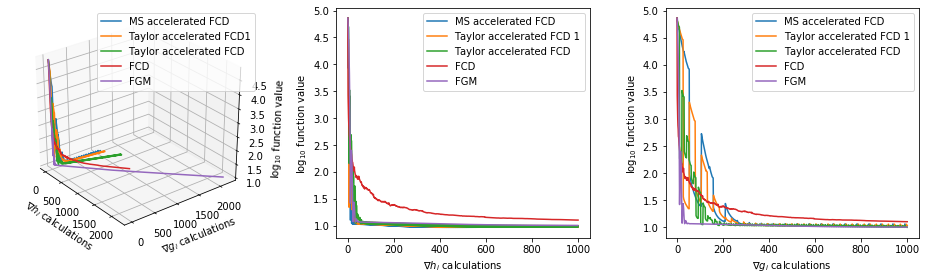

In [1068]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

fig = plt.figure(figsize=(13,4))
fig.tight_layout()
ax = fig.add_subplot(131, projection='3d')

ax.plot(
    grad_h_count_ms_times[:length_grad_plot], 
    grad_g_count_ms_times[:length_grad_plot], 
    np.log10(funcs_ms_times[:length_grad_plot]),
    label="MS accelerated FCD"
)

ax.plot(
    grad_h_count_taylor1_times[:length_grad_plot], 
    grad_g_count_taylor1_times[:length_grad_plot], 
    np.log10(funcs_taylor1_times[:length_grad_plot]),
    label="Taylor accelerated FCD1"
)

ax.plot(
    grad_h_count_taylor2_times[:length_grad_plot], 
    grad_g_count_taylor2_times[:length_grad_plot], 
    np.log10(funcs_taylor2_times[:length_grad_plot]),
    label="Taylor accelerated FCD"
)

# ax.plot(
#     grad_h_count_contract_times[:length_grad_plot], 
#     grad_g_count_contract_times[:length_grad_plot], 
#     np.log10(funcs_contract_times[:length_grad_plot]),
#     label="Contracting accelerated FCD"
# )

ax.plot(
    grad_h_count_times[:length_grad_plot], 
    grad_g_count_times[:length_grad_plot], 
    np.log10(funcs_times[:length_grad_plot]),
    label="FCD"
)

ax.plot(
    grad_h_count_fgm_times[:length_grad_plot], 
    grad_g_count_fgm_times[:length_grad_plot], 
    np.log10(funcs_fgm_times[:length_grad_plot]),
    label="FGM"
)

ax.legend()
ax.set_xlabel("$\\nabla h_i$ calculations")
ax.set_ylabel("$\\nabla g_i$ calculations")
ax.set_zlabel("$\\log_{10}$ function value")
ax.view_init(azim=-38)

ax1 = fig.add_subplot(132)
ax1.plot(
    grad_h_count_ms_times[:ms_grads_h_min_idx], 
    np.log10(funcs_ms_times[:ms_grads_h_min_idx]),
    label="MS accelerated FCD"
)

ax1.plot(
    grad_h_count_taylor1_times[:taylor1_grads_h_min_idx], 
    np.log10(funcs_taylor1_times[:taylor1_grads_h_min_idx]),
    label="Taylor accelerated FCD 1"
)

ax1.plot(
    grad_h_count_taylor2_times[:taylor2_grads_h_min_idx], 
    np.log10(funcs_taylor2_times[:taylor2_grads_h_min_idx]),
    label="Taylor accelerated FCD"
)

# ax1.plot(
#     grad_h_count_contract_times[:contract_grads_h_min_idx], 
#     np.log10(funcs_contract_times[:contract_grads_h_min_idx]),
#     label="Contracting accelerated FCD"
# )

ax1.plot(
    grad_h_count_times[:grads_h_min_idx], 
    np.log10(funcs_times[:grads_h_min_idx]),
    label="FCD"
)

ax1.plot(
    grad_h_count_fgm_times[:fgm_grads_h_min_idx],
    np.log10(funcs_fgm_times[:fgm_grads_h_min_idx]),
    label="FGM"
)

ax1.legend()
ax1.set_xlabel("$\\nabla h_i$ calculations")
ax1.set_ylabel("$\\log_{10}$ function value")

ax2 = fig.add_subplot(133)
ax2.plot(
    grad_g_count_ms_times[:ms_grads_g_min_idx], 
    np.log10(funcs_ms_times[:ms_grads_g_min_idx]),
    label="MS accelerated FCD"
)

ax2.plot(
    grad_g_count_taylor1_times[:taylor1_grads_g_min_idx], 
    np.log10(funcs_taylor1_times[:taylor1_grads_g_min_idx]),
    label="Taylor accelerated FCD 1"
)

ax2.plot(
    grad_g_count_taylor2_times[:taylor2_grads_g_min_idx], 
    np.log10(funcs_taylor2_times[:taylor2_grads_g_min_idx]),
    label="Taylor accelerated FCD"
)

# ax2.plot(
#     grad_g_count_contract_times[:contract_grads_g_min_idx], 
#     np.log10(funcs_contract_times[:contract_grads_g_min_idx]),
#     label="Contracting accelerated FCD"
# )

ax2.plot(
    grad_g_count_times[:grads_g_min_idx], 
    np.log10(funcs_times[:grads_g_min_idx]),
    label="FCD"
)

ax2.plot(
    grad_g_count_fgm_times[:fgm_grads_g_min_idx],
    np.log10(funcs_fgm_times[:fgm_grads_g_min_idx]),
    label="FGM"
)

ax2.legend()
ax2.set_xlabel("$\\nabla g_i$ calculations")
ax2.set_ylabel("$\\log_{10}$ function value")

plt.gcf().tight_layout()
plt.subplots_adjust(wspace = 0.3)

# plt.savefig("ms_taylor_contract_3d.pdf", dpi=200)

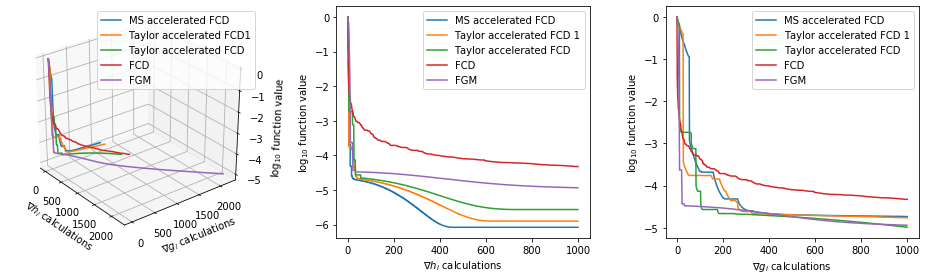

In [1071]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

fig = plt.figure(figsize=(13,4))
fig.tight_layout()
ax = fig.add_subplot(131, projection='3d')

ax.plot(
    grad_h_count_ms_times[:length_grad_plot], 
    grad_g_count_ms_times[:length_grad_plot], 
    np.log10((np.minimum.accumulate(funcs_ms_times)[:length_grad_plot] - func_opt) / (f(x_0) - func_opt)),
    label="MS accelerated FCD"
)

ax.plot(
    grad_h_count_taylor1_times[:length_grad_plot], 
    grad_g_count_taylor1_times[:length_grad_plot], 
    np.log10((np.minimum.accumulate(funcs_taylor1_times)[:length_grad_plot] - func_opt) / (f(x_0) - func_opt)),
    label="Taylor accelerated FCD1"
)

ax.plot(
    grad_h_count_taylor2_times[:length_grad_plot], 
    grad_g_count_taylor2_times[:length_grad_plot], 
    np.log10((np.minimum.accumulate(funcs_taylor2_times)[:length_grad_plot] - func_opt) / (f(x_0) - func_opt)),
    label="Taylor accelerated FCD"
)

# ax.plot(
#     grad_h_count_contract_times[:length_grad_plot], 
#     grad_g_count_contract_times[:length_grad_plot], 
#     np.log10(funcs_contract_times[:length_grad_plot]),
#     label="Contracting accelerated FCD"
# )

ax.plot(
    grad_h_count_times[:length_grad_plot], 
    grad_g_count_times[:length_grad_plot], 
    np.log10((np.minimum.accumulate(funcs_times)[:length_grad_plot] - func_opt) / (f(x_0) - func_opt)),
    label="FCD"
)

ax.plot(
    grad_h_count_fgm_times[:length_grad_plot], 
    grad_g_count_fgm_times[:length_grad_plot], 
    np.log10((np.minimum.accumulate(funcs_fgm_times)[:length_grad_plot] - func_opt) / (f(x_0) - func_opt)),
    label="FGM"
)

ax.legend()
ax.set_xlabel("$\\nabla h_i$ calculations")
ax.set_ylabel("$\\nabla g_i$ calculations")
ax.set_zlabel("$\\log_{10}$ function value")
ax.view_init(azim=-38)

ax1 = fig.add_subplot(132)
ax1.plot(
    grad_h_count_ms_times[:ms_grads_h_min_idx], 
    np.log10((np.minimum.accumulate(funcs_ms_times)[:ms_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="MS accelerated FCD"
)

ax1.plot(
    grad_h_count_taylor1_times[:taylor1_grads_h_min_idx], 
    np.log10((np.minimum.accumulate(funcs_taylor1_times)[:taylor1_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="Taylor accelerated FCD 1"
)

ax1.plot(
    grad_h_count_taylor2_times[:taylor2_grads_h_min_idx], 
    np.log10((np.minimum.accumulate(funcs_taylor2_times)[:taylor2_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="Taylor accelerated FCD"
)

# ax1.plot(
#     grad_h_count_contract_times[:contract_grads_h_min_idx], 
#     np.log10(funcs_contract_times[:contract_grads_h_min_idx]),
#     label="Contracting accelerated FCD"
# )

ax1.plot(
    grad_h_count_times[:grads_h_min_idx], 
    np.log10((np.minimum.accumulate(funcs_times)[:grads_h_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="FCD"
)

ax1.plot(
    grad_h_count_fgm_times[:fgm_grads_h_min_idx],
    np.log10((np.minimum.accumulate(funcs_fgm_times)[:fgm_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="FGM"
)

ax1.legend()
ax1.set_xlabel("$\\nabla h_i$ calculations")
ax1.set_ylabel("$\\log_{10}$ function value")

ax2 = fig.add_subplot(133)
ax2.plot(
    grad_g_count_ms_times[:ms_grads_g_min_idx], 
    np.log10((np.minimum.accumulate(funcs_ms_times)[:ms_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="MS accelerated FCD"
)

ax2.plot(
    grad_g_count_taylor1_times[:taylor1_grads_g_min_idx], 
    np.log10((np.minimum.accumulate(funcs_taylor1_times)[:taylor1_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="Taylor accelerated FCD 1"
)

ax2.plot(
    grad_g_count_taylor2_times[:taylor2_grads_g_min_idx], 
    np.log10((np.minimum.accumulate(funcs_taylor2_times)[:taylor2_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="Taylor accelerated FCD"
)

# ax2.plot(
#     grad_g_count_contract_times[:contract_grads_g_min_idx], 
#     np.log10(funcs_contract_times[:contract_grads_g_min_idx]),
#     label="Contracting accelerated FCD"
# )

ax2.plot(
    grad_g_count_times[:grads_g_min_idx], 
    np.log10((np.minimum.accumulate(funcs_times[:grads_g_min_idx]) - func_opt) / (f(x_0) - func_opt)),
    label="FCD"
)

ax2.plot(
    grad_g_count_fgm_times[:fgm_grads_g_min_idx],
    np.log10((np.minimum.accumulate(funcs_fgm_times)[:fgm_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="FGM"
)

ax2.legend()
ax2.set_xlabel("$\\nabla g_i$ calculations")
ax2.set_ylabel("$\\log_{10}$ function value")

plt.gcf().tight_layout()
plt.subplots_adjust(wspace = 0.3)

# plt.savefig("ms_taylor_contract_3d.pdf", dpi=200)

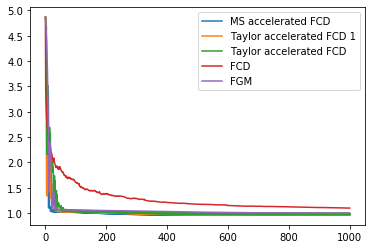

In [1072]:
plt.plot(
    grad_h_count_ms_times[:ms_grads_h_min_idx], 
    np.log10(funcs_ms_times[:ms_grads_h_min_idx]),
    label="MS accelerated FCD"
)

plt.plot(
    grad_h_count_taylor1_times[:taylor1_grads_h_min_idx], 
    np.log10(funcs_taylor1_times[:taylor1_grads_h_min_idx]),
    label="Taylor accelerated FCD 1"
)

plt.plot(
    grad_h_count_taylor2_times[:taylor2_grads_h_min_idx], 
    np.log10(funcs_taylor2_times[:taylor2_grads_h_min_idx]),
    label="Taylor accelerated FCD"
)

plt.plot(
    grad_h_count_times[:grads_h_min_idx], 
    np.log10(funcs_times[:grads_h_min_idx]),
    label="FCD"
)

plt.plot(
    grad_h_count_fgm_times[:fgm_grads_h_min_idx],
    np.log10(funcs_fgm_times[:fgm_grads_h_min_idx]),
    label="FGM"
)

plt.legend()

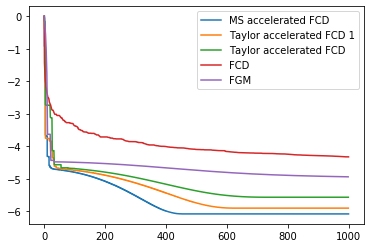

In [1073]:
plt.plot(
    grad_h_count_ms_times[:ms_grads_h_min_idx], 
    np.log10((np.minimum.accumulate(funcs_ms_times)[:ms_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="MS accelerated FCD"
)

plt.plot(
    grad_h_count_taylor1_times[:taylor1_grads_h_min_idx], 
    np.log10((np.minimum.accumulate(funcs_taylor1_times)[:taylor1_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="Taylor accelerated FCD 1"
)

plt.plot(
    grad_h_count_taylor2_times[:taylor2_grads_h_min_idx], 
    np.log10((np.minimum.accumulate(funcs_taylor2_times)[:taylor2_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="Taylor accelerated FCD"
)

plt.plot(
    grad_h_count_times[:grads_h_min_idx], 
    np.log10((np.minimum.accumulate(funcs_times)[:grads_h_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="FCD"
)

plt.plot(
    grad_h_count_fgm_times[:fgm_grads_h_min_idx],
    np.log10((np.minimum.accumulate(funcs_fgm_times)[:fgm_grads_h_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="FGM"
)

plt.legend()

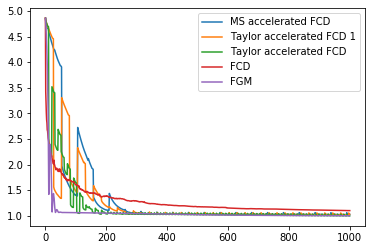

In [1074]:
plt.plot(
    grad_g_count_ms_times[:ms_grads_g_min_idx], 
    np.log10(funcs_ms_times[:ms_grads_g_min_idx]),
    label="MS accelerated FCD"
)

plt.plot(
    grad_g_count_taylor1_times[:taylor1_grads_g_min_idx], 
    np.log10(funcs_taylor1_times[:taylor1_grads_g_min_idx]),
    label="Taylor accelerated FCD 1"
)

plt.plot(
    grad_g_count_taylor2_times[:taylor2_grads_g_min_idx], 
    np.log10(funcs_taylor2_times[:taylor2_grads_g_min_idx]),
    label="Taylor accelerated FCD"
)

plt.plot(
    grad_g_count_times[:grads_g_min_idx], 
    np.log10(funcs_times[:grads_g_min_idx]),
    label="FCD"
)

plt.plot(
    grad_g_count_fgm_times[:fgm_grads_g_min_idx],
    np.log10(funcs_fgm_times[:fgm_grads_g_min_idx]),
    label="FGM"
)

plt.legend()

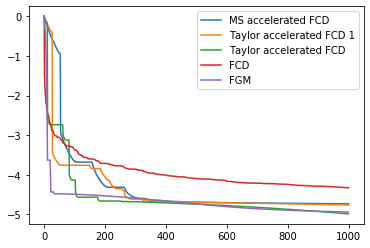

In [1075]:
plt.plot(
    grad_g_count_ms_times[:ms_grads_g_min_idx], 
    np.log10((np.minimum.accumulate(funcs_ms_times)[:ms_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="MS accelerated FCD"
)

plt.plot(
    grad_g_count_taylor1_times[:taylor1_grads_g_min_idx], 
    np.log10((np.minimum.accumulate(funcs_taylor1_times)[:taylor1_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="Taylor accelerated FCD 1"
)

plt.plot(
    grad_g_count_taylor2_times[:taylor2_grads_g_min_idx], 
    np.log10((np.minimum.accumulate(funcs_taylor2_times)[:taylor2_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="Taylor accelerated FCD"
)

plt.plot(
    grad_g_count_times[:grads_g_min_idx], 
    np.log10((np.minimum.accumulate(funcs_times)[:grads_g_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="FCD"
)

plt.plot(
    grad_g_count_fgm_times[:fgm_grads_g_min_idx],
    np.log10((np.minimum.accumulate(funcs_fgm_times)[:fgm_grads_g_min_idx] - func_opt) / (f(x_0) - func_opt)),
    label="FGM"
)

plt.legend()

In [1076]:
# Get working time limit for all methods
time_max = min(
    ms_times[-1] - ms_times[0],
    times[-1] - times[0],
    fgm_times[-1] - fgm_times[0],
    taylor1_times[-1] - taylor1_times[0],
    taylor2_times[-1] - taylor2_times[0]
)

In [1077]:
ms_times[-1] - ms_times[0], times[-1] - times[0], fgm_times[-1] - fgm_times[0], taylor1_times[-1] - taylor1_times[0], taylor2_times[-1] - taylor2_times[0]

(163.71829199790955,
 3.3276209831237793,
 44.785841941833496,
 73.62408924102783,
 48.927470207214355)

In [1078]:
# Get number of iteration, executing at the time `time_max`
ms_times_max_idx = np.searchsorted(np.array(ms_times) - ms_times[0], time_max, side="right")
times_max_idx = np.searchsorted(np.array(times) - times[0], time_max, side="right")
fgm_times_max_idx = np.searchsorted(np.array(fgm_times) - fgm_times[0], time_max, side="right")
taylor1_times_max_idx = np.searchsorted(np.array(taylor1_times) - taylor1_times[0], time_max, side="right")
taylor2_times_max_idx = np.searchsorted(np.array(taylor2_times) - taylor2_times[0], time_max, side="right")

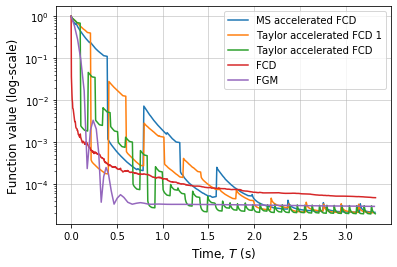

In [1079]:
plt.semilogy((np.array(ms_times) - ms_times[0])[:ms_times_max_idx], (funcs_ms_times - func_opt)[:ms_times_max_idx] / (f(x_0) - func_opt), 
             label="MS accelerated FCD")
plt.semilogy((np.array(taylor1_times) - taylor1_times[0])[:taylor1_times_max_idx], (funcs_taylor1_times - func_opt)[:taylor1_times_max_idx] / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD 1")
plt.semilogy((np.array(taylor2_times) - taylor2_times[0])[:taylor2_times_max_idx], (funcs_taylor2_times - func_opt)[:taylor2_times_max_idx] / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD")
plt.semilogy((np.array(times) - times[0])[:times_max_idx], (funcs_times - func_opt)[:times_max_idx] / (f(x_0) - func_opt), label="FCD")
plt.semilogy((np.array(fgm_times) - fgm_times[0])[:fgm_times_max_idx], (funcs_fgm_times[:fgm_times_max_idx] - func_opt) / (f(x_0) - func_opt), label="FGM")

plt.grid(linewidth=0.5)

plt.xlabel(r"Time, $T$ (s)", fontsize=12)
plt.ylabel(r"Function value (log-scale)", fontsize=12)
plt.legend()

# plt.savefig("ms_taylor_contract_time.pdf", dpi=200)
plt.show()

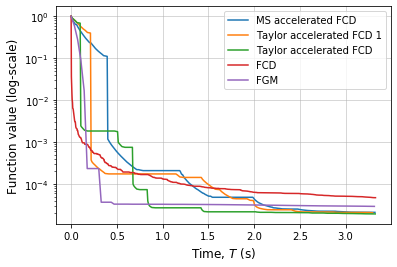

In [1080]:
plt.semilogy((np.array(ms_times) - ms_times[0])[:ms_times_max_idx], (np.minimum.accumulate(funcs_ms_times) - func_opt)[:ms_times_max_idx] / (f(x_0) - func_opt), 
             label="MS accelerated FCD")
plt.semilogy((np.array(taylor1_times) - taylor1_times[0])[:taylor1_times_max_idx], (np.minimum.accumulate(funcs_taylor1_times) - func_opt)[:taylor1_times_max_idx] / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD 1")
plt.semilogy((np.array(taylor2_times) - taylor2_times[0])[:taylor2_times_max_idx], (np.minimum.accumulate(funcs_taylor2_times) - func_opt)[:taylor2_times_max_idx] / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD")
plt.semilogy((np.array(times) - times[0])[:times_max_idx], (np.minimum.accumulate(funcs_times) - func_opt)[:times_max_idx] / (f(x_0) - func_opt), label="FCD")
plt.semilogy((np.array(fgm_times) - fgm_times[0])[:fgm_times_max_idx], (np.minimum.accumulate(funcs_fgm_times[:fgm_times_max_idx]) - func_opt) / (f(x_0) - func_opt), label="FGM")

plt.grid(linewidth=0.5)

plt.xlabel(r"Time, $T$ (s)", fontsize=12)
plt.ylabel(r"Function value (log-scale)", fontsize=12)
plt.legend()

# plt.savefig("ms_taylor_contract_time.pdf", dpi=200)
plt.show()

In [1081]:
# Get number of iteration, executing at the time 0.5 s
time_min = 0.6

ms_times_min_idx = np.searchsorted(np.array(ms_times) - ms_times[0], time_min, side="right")
times_min_idx = np.searchsorted(np.array(times) - times[0], time_min, side="right")
fgm_times_min_idx = np.searchsorted(np.array(fgm_times) - fgm_times[0], time_min, side="right")
taylor1_times_min_idx = np.searchsorted(np.array(taylor1_times) - taylor1_times[0], time_min, side="right")
taylor2_times_min_idx = np.searchsorted(np.array(taylor2_times) - taylor2_times[0], time_min, side="right")

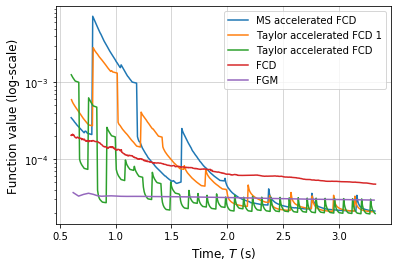

In [1082]:
plt.semilogy((np.array(ms_times) - ms_times[0])[ms_times_min_idx:ms_times_max_idx], (funcs_ms_times - func_opt)[ms_times_min_idx:ms_times_max_idx] / (f(x_0) - func_opt), 
             label="MS accelerated FCD")
plt.semilogy((np.array(taylor1_times) - taylor1_times[0])[taylor1_times_min_idx:taylor1_times_max_idx], (funcs_taylor1_times - func_opt)[taylor1_times_min_idx:taylor1_times_max_idx] / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD 1")
plt.semilogy((np.array(taylor2_times) - taylor2_times[0])[taylor2_times_min_idx:taylor2_times_max_idx], (funcs_taylor2_times - func_opt)[taylor2_times_min_idx:taylor2_times_max_idx] / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD")
plt.semilogy((np.array(times) - times[0])[times_min_idx:times_max_idx], (funcs_times - func_opt)[times_min_idx:times_max_idx] / (f(x_0) - func_opt), label="FCD")
plt.semilogy((np.array(fgm_times) - fgm_times[0])[fgm_times_min_idx:fgm_times_max_idx], (funcs_fgm_times[fgm_times_min_idx:fgm_times_max_idx] - func_opt) / (f(x_0) - func_opt), label="FGM")

plt.grid(linewidth=0.5)

plt.xlabel(r"Time, $T$ (s)", fontsize=12)
plt.ylabel(r"Function value (log-scale)", fontsize=12)
plt.legend(loc='upper right')

# plt.savefig("ms_taylor_contract_time_detailed.pdf", dpi=200)
plt.show()

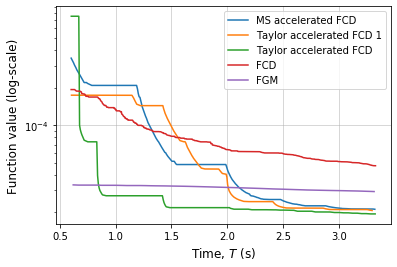

In [1083]:
plt.semilogy((np.array(ms_times) - ms_times[0])[ms_times_min_idx:ms_times_max_idx], (np.minimum.accumulate(funcs_ms_times) - func_opt)[ms_times_min_idx:ms_times_max_idx] / (f(x_0) - func_opt), 
             label="MS accelerated FCD")
plt.semilogy((np.array(taylor1_times) - taylor1_times[0])[taylor1_times_min_idx:taylor1_times_max_idx], (np.minimum.accumulate(funcs_taylor1_times) - func_opt)[taylor1_times_min_idx:taylor1_times_max_idx] / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD 1")
plt.semilogy((np.array(taylor2_times) - taylor2_times[0])[taylor2_times_min_idx:taylor2_times_max_idx], (np.minimum.accumulate(funcs_taylor2_times) - func_opt)[taylor2_times_min_idx:taylor2_times_max_idx] / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD")
plt.semilogy((np.array(times) - times[0])[times_min_idx:times_max_idx], (np.minimum.accumulate(funcs_times) - func_opt)[times_min_idx:times_max_idx] / (f(x_0) - func_opt), label="FCD")
plt.semilogy((np.array(fgm_times) - fgm_times[0])[fgm_times_min_idx:fgm_times_max_idx], (np.minimum.accumulate(funcs_fgm_times)[fgm_times_min_idx:fgm_times_max_idx] - func_opt) / (f(x_0) - func_opt), label="FGM")

plt.grid(linewidth=0.5)

plt.xlabel(r"Time, $T$ (s)", fontsize=12)
plt.ylabel(r"Function value (log-scale)", fontsize=12)
plt.legend(loc='upper right')

# plt.savefig("ms_taylor_contract_time_detailed.pdf", dpi=200)
plt.show()

In [1084]:
# Get iterations limit for all methods
length = min(
    funcs_ms_times.shape[0],
    funcs_times.shape[0],
    funcs_fgm_times.shape[0],
    funcs_taylor1_times.shape[0],
    funcs_taylor2_times.shape[0]
)

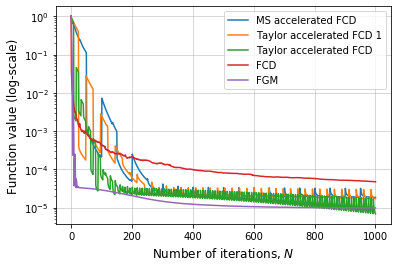

In [1085]:
plt.semilogy((funcs_ms_times[:length] - func_opt) / (f(x_0) - func_opt), 
             label="MS accelerated FCD")
plt.semilogy((funcs_taylor1_times[:length] - func_opt) / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD 1")
plt.semilogy((funcs_taylor2_times[:length] - func_opt) / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD")
plt.semilogy((funcs_times[:length] - func_opt) / (f(x_0) - func_opt), label="FCD")
plt.semilogy((funcs_fgm_times[:length] - func_opt) / (f(x_0) - func_opt), label="FGM")
plt.grid(linewidth=0.5)

plt.xlabel(r"Number of iterations, $N$", fontsize=12)
plt.ylabel(r"Function value (log-scale)", fontsize=12)
plt.legend()

# plt.savefig("ms_taylor_contract_iters.pdf", dpi=200)
plt.show()

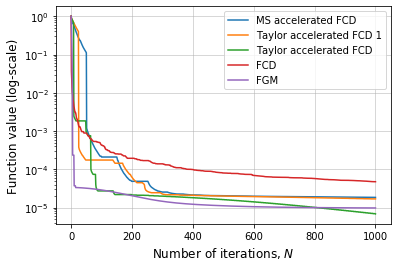

In [1086]:
plt.semilogy((np.minimum.accumulate(funcs_ms_times)[:length] - func_opt) / (f(x_0) - func_opt), 
             label="MS accelerated FCD")
plt.semilogy((np.minimum.accumulate(funcs_taylor1_times)[:length] - func_opt) / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD 1")
plt.semilogy((np.minimum.accumulate(funcs_taylor2_times)[:length] - func_opt) / (f(x_0) - func_opt), 
             label="Taylor accelerated FCD")
plt.semilogy((np.minimum.accumulate(funcs_times)[:length] - func_opt) / (f(x_0) - func_opt), label="FCD")
plt.semilogy((np.minimum.accumulate(funcs_fgm_times)[:length] - func_opt) / (f(x_0) - func_opt), label="FGM")
plt.grid(linewidth=0.5)

plt.xlabel(r"Number of iterations, $N$", fontsize=12)
plt.ylabel(r"Function value (log-scale)", fontsize=12)
plt.legend()

# plt.savefig("ms_taylor_contract_iters.pdf", dpi=200)
plt.show()